In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
# Set display option to show all columns
pd.set_option('display.max_columns', None)

# 1. Load Training and Testing Dataframe

In [2]:
# Load DataFrame from the feather file
train_df = pd.read_feather('train_df.feather')

In [3]:
train_df

,Transaction_id,Sender_account,Receiver_account,Sender_bank_location,Receiver_bank_location,Payment_type,Last_transaction_time_elapsed_minutes,Amount_USD,Sender_bank_location_risk,Receiver_bank_location_risk,Payment_type_risk,Different_Currency,sender_f_degree_in,sender_f_degree_out,sender_f_amount_in,sender_f_amount_out,sender_f_nr_trans_in,sender_f_nr_trans_out,sender_f_average_amount_in,sender_f_average_amount_out,sender_f_ego_edge_density,sender_f_egored_degree_in,sender_f_egored_degree_out,sender_f_egored_amount_in,sender_f_egored_amount_out,sender_f_egored_nr_trans_in,sender_f_egored_nr_trans_out,sender_f_egored_average_amount_in,sender_f_egored_average_amount_out,sender_f_egored_edge_density,sender_f_egored_degree_in_rel,sender_f_egored_degree_out_rel,sender_f_egored_amount_in_rel,sender_f_egored_amount_out_rel,sender_f_egored_average_amount_in_rel,sender_f_egored_average_amount_out_rel,sender_max_cycle_length,sender_cycle_total_amount_USD,receiver_f_degree_in,receiver_f_degree_out,receiver_f_amount_in,receiver_f_amount_out,receiver_f_nr_trans_in,receiver_f_nr_trans_out,receiver_f_average_amount_in,receiver_f_average_amount_out,receiver_f_ego_edge_density,receiver_f_egored_degree_in,receiver_f_egored_degree_out,receiver_f_egored_amount_in,receiver_f_egored_amount_out,receiver_f_egored_nr_trans_in,receiver_f_egored_nr_trans_out,receiver_f_egored_average_amount_in,receiver_f_egored_average_amount_out,receiver_f_egored_edge_density,receiver_f_egored_degree_in_rel,receiver_f_egored_degree_out_rel,receiver_f_egored_amount_in_rel,receiver_f_egored_amount_out_rel,receiver_f_egored_average_amount_in_rel,receiver_f_egored_average_amount_out_rel,receiver_max_cycle_length,receiver_cycle_total_amount_USD,Is_laundering,Laundering_type
5390771,T6977154,3925886128,4465759925,USA,UK,Cross-border,245.816667,6808.720000,4,4,7,1,16,42,3.053331e+06,3.876100e+06,189,521,16155.193014,7439.731797,1.000000,1,1,84157.731216,105564.555720,4,5,21039.432804,21112.911144,1.000000,0.062500,0.023810,0.027563,0.027235,1.302332,2.837859,2,189722.286936,1,0,8.082458e+04,0.000000e+00,12,0,6735.381667,0.000000,0.500000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,Normal_Periodical
7609415,T5909903,7198690908,1323360869,UK,UK,Debit card,0.000000,3719.166516,4,4,2,0,1,1,3.719167e+03,3.719167e+03,1,1,3719.166516,3719.166516,0.666667,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,1,0,3.719167e+03,0.000000e+00,1,0,3719.166516,0.000000,0.500000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,Normal_Foward
1926516,T8510862,3421266864,5679572583,France,UK,Cross-border,16.966667,13640.508488,4,4,7,1,0,1,0.000000e+00,1.648325e+05,0,12,0.000000,13736.038693,0.500000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,19,3,3.020554e+06,4.823852e+05,220,7,13729.791678,68912.164353,1.000000,1,1,372308.999400,466169.637024,4,5,93077.249850,93233.927405,1.000000,0.052632,0.333333,0.123259,0.966385,6.779218,1.352939,2,838478.636424,0,Normal_Fan_In
1295051,T747042,4322968771,3565104110,UK,UK,Debit card,0.000000,13096.038852,4,4,2,0,0,1,0.000000e+00,1.567974e+05,0,12,0.000000,13066.451658,0.500000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,19,47,2.382705e+06,4.390533e+06,203,534,11737.463750,8221.972017,1.015385,2,2,228112.122888,558217.097100,7,4,32587.446127,139554.274275,1.333333,0.105263,0.042553,0.095737,0.127141,2.776362,16.973334,2,677182.168728,0,Normal_Fan_In
1454362,T2660645,8262348471,5905719008,UK,UK,Debit card,168.400000,30121.936884,4,4,2,0,0,1,0.000000e+00,3.633101e+05,0,12,0.000000,30275.843364,0.500000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [3]:
test_df = pd.read_feather('test.feather')

In [4]:
print(f"Number of Training samples: {len(train_df)}")
print(f"Number of Testing samples: {len(test_df)}")

Number of Training samples: 6653396
Number of Testing samples: 2851456


# 2. Use the proposed Imbalanced Training Methodology

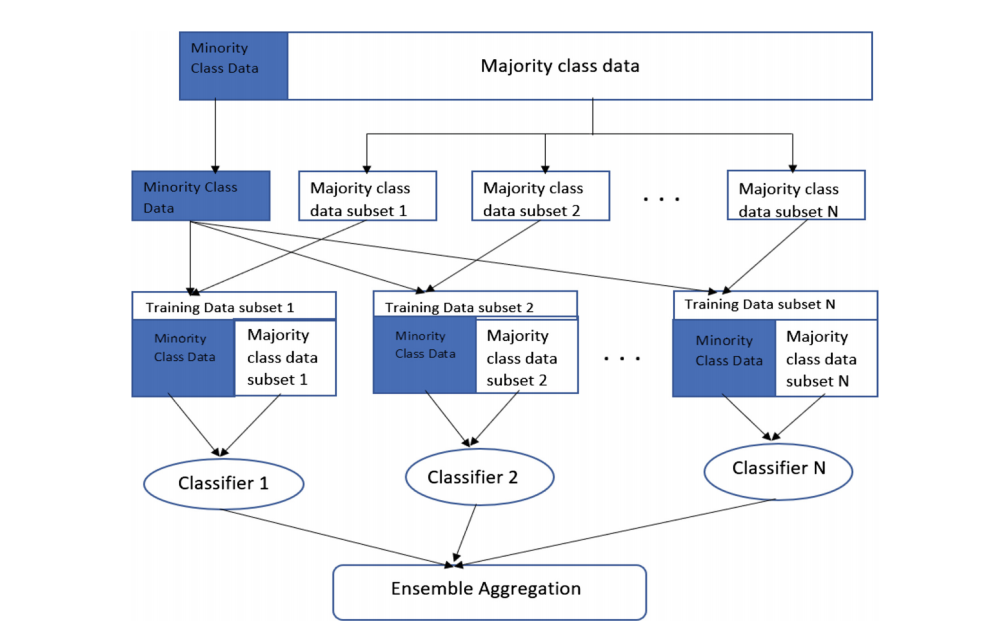

## 2.1 Prepare 9 Training Subsets 

In [5]:
from util import split_subsets

mask = train_df['Is_laundering'] == 0

majority_df = train_df[mask]

# Split the majority_df into n subsets
subsets = split_subsets(df=majority_df, n=9, stratify=["Laundering_type"], verbose=True)

Subset: 1 is ready
Subset: 2 is ready
Subset: 3 is ready
Subset: 4 is ready
Subset: 5 is ready
Subset: 6 is ready
Subset: 7 is ready
Subset: 8 is ready
Subset: 9 is ready


In [6]:
import pickle

# Save the model to a file
with open("subsets.pkl", "wb") as f:
    pickle.dump(subsets, f)

In [7]:
import pickle

# Load the model from the file
with open("subsets.pkl", "rb") as f:
    subsets = pickle.load(f)

## 2.2 Combine minority class data into each subset

In [8]:
mask = train_df['Is_laundering'] == 1

minority_df = train_df[mask]

# del train_df

In [9]:
# Combine minority_df into each subset
for i in range(len(subsets)):
    # Concatenate vertically
    result_df = pd.concat([subsets[i], minority_df], axis=0, ignore_index=True)
    subsets[i] = result_df
    print(f"Concatenation process for subset {i+1} is done.")

Concatenation process for subset 1 is done.
Concatenation process for subset 2 is done.
Concatenation process for subset 3 is done.
Concatenation process for subset 4 is done.
Concatenation process for subset 5 is done.
Concatenation process for subset 6 is done.
Concatenation process for subset 7 is done.
Concatenation process for subset 8 is done.
Concatenation process for subset 9 is done.


## 2.3 Prepare X_train_list and y_train_list

In [11]:
X_train_list = []
y_train_list = []
columns_to_drop = [
    'Transaction_id', 'Sender_account', 'Receiver_account',
    'Sender_bank_location', 'Receiver_bank_location', 'Payment_type',
    'Is_laundering', 'Laundering_type'
]
for i in range(len(subsets)):
    X_train = subsets[i].drop(columns_to_drop, axis=1)
    y_train = subsets[i]['Is_laundering']
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    print(f"X_train and y_train preparation for subset {i+1} is done.")


X_train and y_train preparation for subset 1 is done.
X_train and y_train preparation for subset 2 is done.
X_train and y_train preparation for subset 3 is done.
X_train and y_train preparation for subset 4 is done.
X_train and y_train preparation for subset 5 is done.
X_train and y_train preparation for subset 6 is done.
X_train and y_train preparation for subset 7 is done.
X_train and y_train preparation for subset 8 is done.
X_train and y_train preparation for subset 9 is done.


## 2.4 Prepare X_test, y_test

In [14]:
columns_to_drop = [
    'Transaction_id', 'Sender_account', 'Receiver_account',
    'Sender_bank_location', 'Receiver_bank_location', 'Payment_type',
    'Is_laundering', 'Laundering_type'
]
X_test = test_df.drop(columns_to_drop, axis=1)
y_test = test_df['Is_laundering']

# 3. Machine Learning with XGBoost

## 3.1 Create a XGBoost Voting Classifier

In [15]:
import xgboost as xgb
import numpy as np

class XGBoostVotingClassifier():
    def __init__(self, n_estimators=3):
        self.n_estimators = n_estimators
        self.estimators_ = []
        self.is_fitted = False

    def fit(self, X_list, y_list, verbose=False):
        for i in range(self.n_estimators):
            X = X_list[i]
            y = y_list[i]
            model = xgb.XGBClassifier()
            model.fit(X, y)
            self.estimators_.append(model)

            if verbose:
                print(f"Model {i+1} is fitted.")

        self.is_fitted = True

    def predict(self, X, voting='hard'):
        if self.is_fitted:
            predictions = []
            for model in self.estimators_:
                if voting == 'hard':
                    predictions.append(model.predict(X))
                elif voting == 'soft':
                    predictions.append(model.predict_proba(X))
                else:
                    raise ValueError("Invalid voting type. Please choose 'hard' or 'soft'.")

            if voting == 'hard':
                predictions = np.array(predictions)
                ensemble_predictions = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=predictions)
            elif voting == 'soft':
                predictions = np.mean(predictions, axis=0)
                ensemble_predictions = np.argmax(predictions, axis=1)

            return ensemble_predictions
        else:
            raise ValueError("Model is not fitted yet. Call fit method first.")
            
    def predict_proba(self, X):
        if self.is_fitted:
            # Collect probabilities from each model
            probabilities = []
            for model in self.estimators_:
                probabilities.append(model.predict_proba(X))
            
            # Average probabilities across all models
            avg_probabilities = np.mean(probabilities, axis=0)
            return avg_probabilities
        else:
            raise ValueError("Model is not fitted yet. Call fit method first.")
    

## 3.2 Train the XGBoost Voting Classifier

In [16]:
xgboost_voter = XGBoostVotingClassifier(n_estimators=9)

In [17]:
xgboost_voter.fit(X_train_list, y_train_list, verbose=True)

Model 1 is fitted.
Model 2 is fitted.
Model 3 is fitted.
Model 4 is fitted.
Model 5 is fitted.
Model 6 is fitted.
Model 7 is fitted.
Model 8 is fitted.
Model 9 is fitted.


In [18]:
del subsets

Confusion Matrix:
[[2848488       5]
 [      0    2963]]


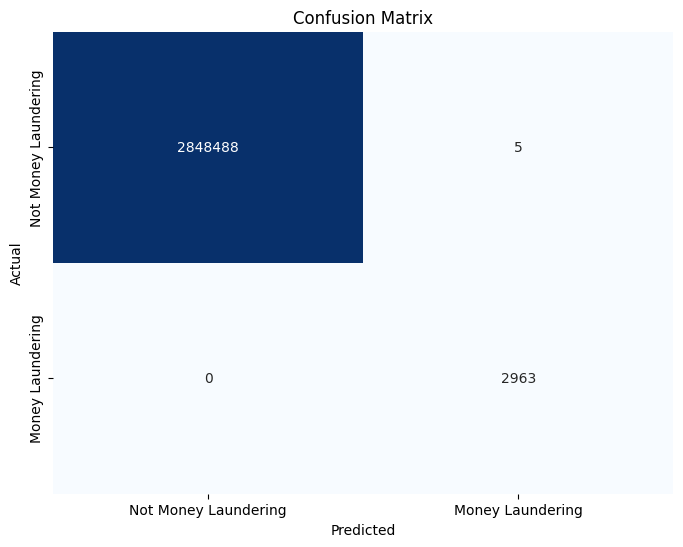

Precision: 99.83153638814017 %
Recall: 100.0 %
F1 Score: 99.91569718428595 %
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2848493
           1       1.00      1.00      1.00      2963

    accuracy                           1.00   2851456
   macro avg       1.00      1.00      1.00   2851456
weighted avg       1.00      1.00      1.00   2851456

----------------------------------------------------------------------------------------------------





In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Predictions on the test set
y_pred = xgboost_voter.predict(X_test, voting="soft")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Not Money Laundering', 'Money Laundering'], 
            yticklabels=['Not Money Laundering', 'Money Laundering'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision * 100} %")
print(f"Recall: {recall * 100} %")
print(f"F1 Score: {f1 * 100} %")

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)
print("-" * 100)
print('\n\n')

In [20]:
import pickle

# Save the model to a file
with open("xgboost_voter_model.pkl", "wb") as f:
    pickle.dump(xgboost_voter, f)

In [21]:
import pickle

# Load the model from the file
with open("xgboost_voter_model.pkl", "rb") as f:
    xgboost_voter = pickle.load(f)

## 3.4 Visualize Feature Importance

In [22]:
# Average the feature importance value from all estimators
feature_importances_list = []
for model in xgboost_voter.estimators_:
    feature_importances_list.append(model.feature_importances_)
value = np.mean(feature_importances_list, axis=0)

These are the top 15 important features: 

['sender_f_degree_out', 'receiver_f_degree_out', 'receiver_f_degree_in', 'sender_f_egored_nr_trans_in', 'receiver_f_egored_degree_in_rel', 'sender_f_degree_in', 'sender_f_nr_trans_in', 'sender_f_amount_out', 'receiver_f_egored_degree_out_rel', 'sender_f_egored_average_amount_out_rel', 'sender_f_egored_nr_trans_out', 'sender_f_average_amount_in', 'receiver_f_egored_nr_trans_in', 'sender_f_egored_degree_out_rel', 'sender_f_egored_amount_out_rel']


C:\Users\jthxc\AppData\Local\Temp\ipykernel_4556\303099680.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df[:top_k], palette="viridis")


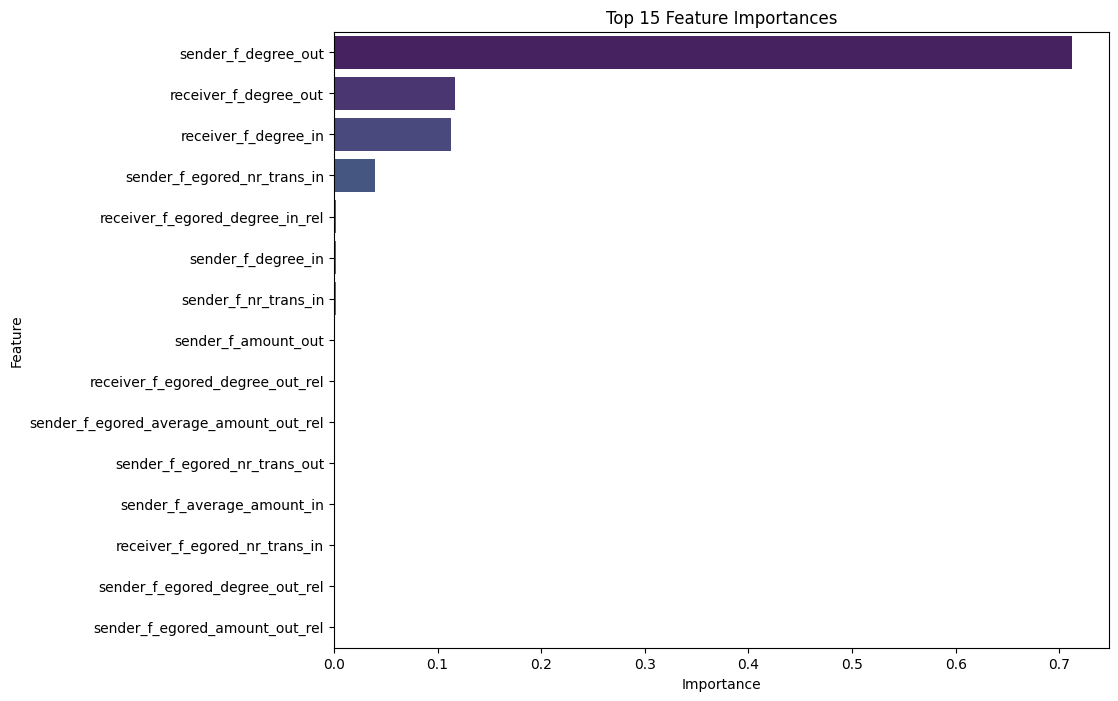

In [23]:
# Feature Importances
feature_importances = value

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print top features
top_k = 15
print(f"These are the top {top_k} important features: \n")
top_features = list(feature_importance_df[:top_k]['Feature'].values)
print(top_features)


# Plot Feature Importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df[:top_k], palette="viridis")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_k} Feature Importances')
plt.show()

## 3.5 Select Important Features for Model Retraining

In [24]:
# select a few transaction features and top 15 important features from xgboost_voter for retraining
selected_columns = ['Last_transaction_time_elapsed_minutes', 'Amount_USD', 'Sender_bank_location_risk',
                    'Receiver_bank_location_risk', 'Payment_type_risk',
                    'Different_Currency', 'sender_f_degree_out', 'receiver_f_degree_out', 
                    'receiver_f_degree_in', 'sender_f_egored_nr_trans_in', 
                    'receiver_f_egored_degree_in_rel', 'sender_f_degree_in', 
                    'sender_f_nr_trans_in', 'sender_f_amount_out', 
                    'receiver_f_egored_degree_out_rel', 'sender_f_egored_average_amount_out_rel', 
                    'sender_f_egored_nr_trans_out', 'sender_f_average_amount_in', 
                    'receiver_f_egored_nr_trans_in', 'sender_f_egored_degree_out_rel', 
                    'sender_f_egored_amount_out_rel']

In [25]:
# Select neccesary columns only for X_train_list
for i, X_train in enumerate(X_train_list):
    X_train_list[i] = X_train_list[i][selected_columns]

In [26]:
# Select neccesary columns only for X_test_list
X_test = X_test[selected_columns]

In [27]:
xgboost_voter = XGBoostVotingClassifier(n_estimators=9)

In [28]:
xgboost_voter.fit(X_train_list, y_train_list, verbose=True)

Model 1 is fitted.
Model 2 is fitted.
Model 3 is fitted.
Model 4 is fitted.
Model 5 is fitted.
Model 6 is fitted.
Model 7 is fitted.
Model 8 is fitted.
Model 9 is fitted.


Confusion Matrix:
[[2848491       2]
 [      0    2963]]


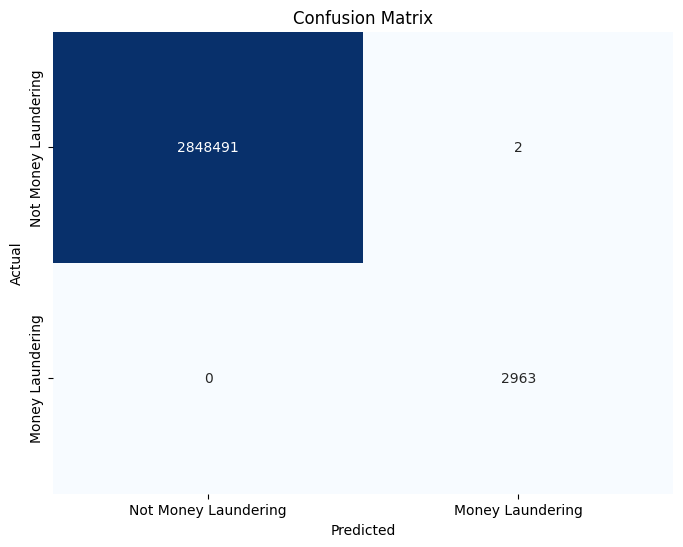

Precision: 99.93254637436763 %
Recall: 100.0 %
F1 Score: 99.96626180836708 %
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2848493
           1       1.00      1.00      1.00      2963

    accuracy                           1.00   2851456
   macro avg       1.00      1.00      1.00   2851456
weighted avg       1.00      1.00      1.00   2851456

----------------------------------------------------------------------------------------------------





In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Predictions on the test set
y_pred = xgboost_voter.predict(X_test, voting="soft")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Not Money Laundering', 'Money Laundering'], 
            yticklabels=['Not Money Laundering', 'Money Laundering'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision * 100} %")
print(f"Recall: {recall * 100} %")
print(f"F1 Score: {f1 * 100} %")

# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)
print("-" * 100)
print('\n\n')

In [30]:
import pickle

# Save the model to a file
with open("xgboost_voter_model.pkl", "wb") as f:
    pickle.dump(xgboost_voter, f)

In [32]:
import pickle

# Save the feature list to a file
with open("selected_columns.pkl", "wb") as f:
    pickle.dump(selected_columns, f)

In [31]:
import pickle

# Load the model from the file
with open("xgboost_voter_model.pkl", "rb") as f:
    xgboost_voter = pickle.load(f)

In [33]:
import pickle

# Load the feature list from the file
with open("selected_columns.pkl", "rb") as f:
    selected_columns = pickle.load(f)

## 3.6 Implement Simple Deployment for XGBoost Voter

In [34]:
additional_columns = ['Is_laundering', 'Laundering_type']
selected_columns += additional_columns
test_df = test_df[selected_columns]

In [35]:
# random select an index from test_df to predict
mask = test_df['Is_laundering'] == 1
laundering_index = np.random.choice(test_df[mask].index)
test_transaction = test_df[mask].loc[laundering_index].drop(['Is_laundering', 'Laundering_type'], axis=0)
print(f"{test_transaction}")
test_transaction = test_transaction.values

Last_transaction_time_elapsed_minutes        2061.916667
Amount_USD                                   6574.434984
Sender_bank_location_risk                              4
Receiver_bank_location_risk                            4
Payment_type_risk                                      1
Different_Currency                                     0
sender_f_degree_out                                   34
receiver_f_degree_out                                  4
receiver_f_degree_in                                  15
sender_f_egored_nr_trans_in                            0
receiver_f_egored_degree_in_rel                 0.133333
sender_f_degree_in                                     1
sender_f_nr_trans_in                                  12
sender_f_amount_out                       2758960.956354
receiver_f_egored_degree_out_rel                     0.5
sender_f_egored_average_amount_out_rel               0.0
sender_f_egored_nr_trans_out                           0
sender_f_average_amount_in     

In [36]:
x = np.array([test_transaction])

if xgboost_voter.predict(x)[0] == 0:
    print(f"Transaction is clean")
else:
    print(f"Transaction is SUSPICIOUS !!!")


Transaction is SUSPICIOUS !!!


## 3.7 Implement LIME Explainer and Save it for Deployment

In [37]:
import pickle

# Load the feature list from the file
with open("selected_columns.pkl", "rb") as f:
    selected_columns = pickle.load(f)

In [38]:
X_train = train_df.drop(['Is_laundering', 'Laundering_type'], axis=1)

In [39]:
X_train = X_train[selected_columns]

In [41]:
import numpy as np
import lime
import lime.lime_tabular
from __future__ import print_function
np.random.seed(1)

In [42]:
# Create an explainer object
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, 
                                                   training_labels=train_df['Is_laundering'], 
                                                   class_names=np.array(['Not Suspicious', 'Suspicious']), 
                                                   mode='classification')

In [53]:
mask = test_df['Is_laundering'] == 1
laundering_index = np.random.choice(test_df[mask].index)
test_transaction = test_df[mask].loc[laundering_index].drop(['Is_laundering', 'Laundering_type'], axis=0)
print(f"{type(test_transaction)}")
print(f"{test_transaction}")
test_transaction = test_transaction.values

<class 'pandas.core.series.Series'>
Last_transaction_time_elapsed_minutes      2975.183333
Amount_USD                                 5084.461044
Sender_bank_location_risk                            4
Receiver_bank_location_risk                          4
Payment_type_risk                                    3
Different_Currency                                   0
sender_f_degree_out                                  5
receiver_f_degree_out                                3
receiver_f_degree_in                                50
sender_f_egored_nr_trans_in                          4
receiver_f_egored_degree_in_rel                   0.02
sender_f_degree_in                                   8
sender_f_nr_trans_in                                88
sender_f_amount_out                       402680.25238
receiver_f_egored_degree_out_rel              0.333333
sender_f_egored_average_amount_out_rel         3.38179
sender_f_egored_nr_trans_out                         1
sender_f_average_amount_in   

In [54]:
num_features = 10
exp = lime_explainer.explain_instance(test_transaction, xgboost_voter.predict_proba, num_features=num_features)
exp.show_in_notebook(show_table=True, show_all=True)

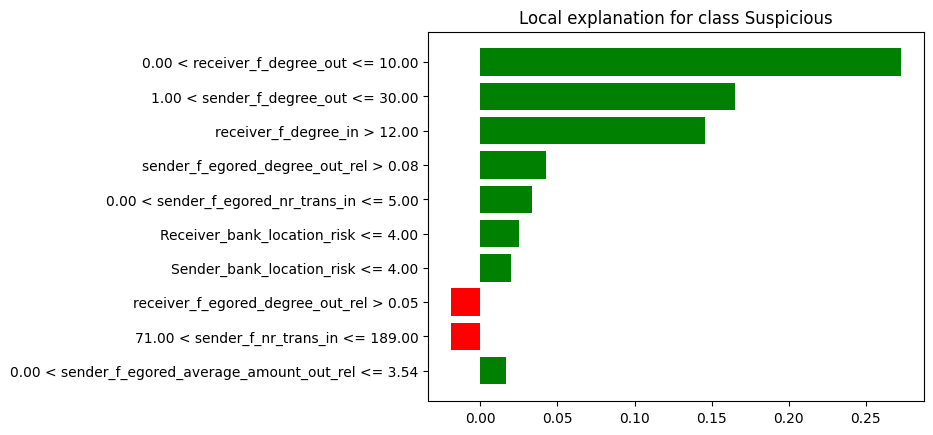

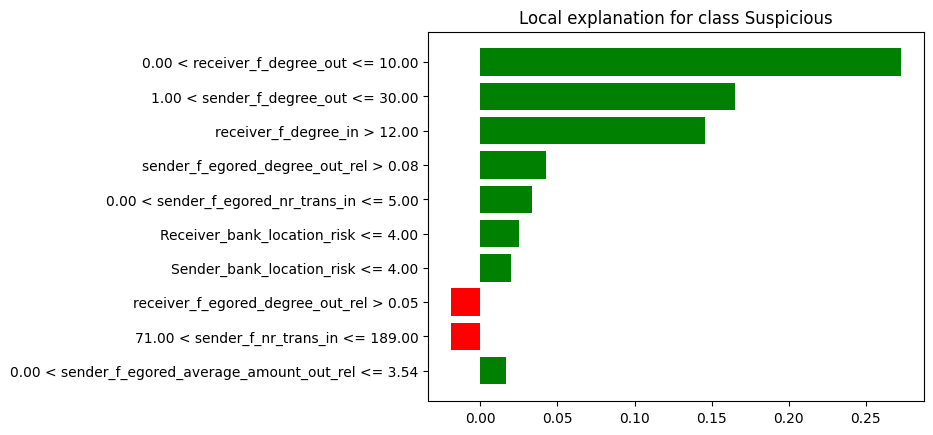

In [55]:
exp.as_pyplot_figure()

In [56]:
import dill

# Save the model to a file
file_path = "lime_explainer.pkl"
with open(file_path, "wb") as f:
    dill.dump(lime_explainer, f)

In [57]:
import dill

# Load the model from the file
file_path = "lime_explainer.pkl"
with open(file_path, "rb") as f:
    lime_explainer = dill.load(f)